In [1]:
! pip install Sastrawi
import string
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import io
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import xgboost as xgb
import random
from nltk.corpus import stopwords, wordnet, sentiwordnet as swn
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 10.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [2]:
df = pd.read_excel('DataTweet.xlsx')  # Sesuaikan nama file
df

,Tweet,label
0,Kami wajib melindungi anak-anak dari promosi L...,kontra
1,Kemunculan remaja laki-laki yang berdandan sep...,kontra
2,@oppaiinthesky Kalo lgbt jangan ditemenin biar...,kontra
3,"Mau lu hetero, mau lu lgbt lu semua menjijikan...",kontra
4,Surat terbuka dan penting untuk Hetero homopho...,kontra
...,...,...
999,ada yang tahu gay lesbian bar ygcozy di jakart...,pro
1000,Serius ngga ada yang bisa komit cuma sama satu...,pro
1001,HADEHH .... PLEASE YA BUAT MEREKA YANG ANTI LG...,pro
1002,"#LGBT #lgbtindonesia Help me please, kalo ada ...",kontra


In [3]:
# Case Folding
def case_folding(text):
 text = text.lower()
 return text
df['Tweet'] = df['Tweet'].apply(case_folding)
df.head()

,Tweet,label
0,kami wajib melindungi anak-anak dari promosi l...,kontra
1,kemunculan remaja laki-laki yang berdandan sep...,kontra
2,@oppaiinthesky kalo lgbt jangan ditemenin biar...,kontra
3,"mau lu hetero, mau lu lgbt lu semua menjijikan...",kontra
4,surat terbuka dan penting untuk hetero homopho...,kontra


In [4]:
# Cleaning: pembersihan kalimat dari atribut-atribut yang mengganggu
def cleaning(text):
    # Menghapus kata yang diawali dengan '@' (username)
    text = re.sub(r"@\w+", "", text)
    # Menghapus kata yang diawali dengan '#' (hashtag)
    text = re.sub(r"#\w+", "", text)
    # Menghapus karakter angka
    text = re.sub(r"\d+", "", text)
    # Menghapus karakter tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Menghapus karakter kosong
    text = text.strip()
    return text

# Mengaplikasikan fungsi ke kolom 'Tweet'
df['Tweet'] = df['Tweet'].apply(cleaning)


df

,Tweet,label
0,kami wajib melindungi anakanak dari promosi lg...,kontra
1,kemunculan remaja lakilaki yang berdandan sepe...,kontra
2,kalo lgbt jangan ditemenin biar aja sendiri du...,kontra
3,mau lu hetero mau lu lgbt lu semua menjijikan ...,kontra
4,surat terbuka dan penting untuk hetero homopho...,kontra
...,...,...
999,ada yang tahu gay lesbian bar ygcozy di jakart...,pro
1000,serius ngga ada yang bisa komit cuma sama satu...,pro
1001,hadehh please ya buat mereka yang anti lgbtq ...,pro
1002,help me please kalo ada kekeliruan dgn stateme...,kontra


In [ ]:
import re
import string
import pandas as pd
# Cleaning : pembersihan kalimat dari atribut-atribut yang mengganggu, seperti angka, tanda baca, dan karakter kosong
def cleaning(text):
 # Menghapus karakter angka.
 text = re.sub(r"\d+", "", text)
 # Menghapus karakter tanda baca.
 text = text.translate(str.maketrans("","",string.punctuation))
 # Menghapus karakter kosong.
 text = text.strip()

 return text
df['Tweet'] = df['Tweet'].apply(cleaning)
df.head()

,Tweet,label
0,ya karena lgbt dan straight itu basednya nafsu...,pro
1,yoon kadang aku aneh sama orang yg pemikiran n...,pro
2,ngakak banget si badut ini dikata caper hadeh ...,pro
3,mengingatkan baik agar jangan lgbt pun termasu...,pro
4,dri kecil dah kenal per lgbt an ntar dari ceri...,pro


In [5]:
typo_df = pd.read_csv('kamus_normalisasi.csv')
typo_dict = dict(zip(typo_df['typo'], typo_df['perbaikan']))


In [6]:
def correct_typos(text):
    words = text.split()
    corrected_words = [typo_dict[word] if word in typo_dict else word for word in words]
    return ' '.join(corrected_words)
df['Tweet'] = df['Tweet'].apply(correct_typos)
df.head()

,Tweet,label
0,kami wajib melindungi anakanak dari promosi lg...,kontra
1,kemunculan remaja lakilaki yang berdandan sepe...,kontra
2,kalau lgbt jangan ditemani biar saja sendiri d...,kontra
3,mau kamu hetero mau kamu lgbt kamu semua menji...,kontra
4,surat terbuka dan penting untuk hetero homopho...,kontra


In [7]:
def tokenize(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text.lower())
    return text.split()
df['Tweet'] = df['Tweet'].apply(tokenize)
df.head()

,Tweet,label
0,"[kami, wajib, melindungi, anakanak, dari, prom...",kontra
1,"[kemunculan, remaja, lakilaki, yang, berdandan...",kontra
2,"[kalau, lgbt, jangan, ditemani, biar, saja, se...",kontra
3,"[mau, kamu, hetero, mau, kamu, lgbt, kamu, sem...",kontra
4,"[surat, terbuka, dan, penting, untuk, hetero, ...",kontra


In [8]:
stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]
df['Tweet'] = df['Tweet'].apply(remove_stopwords)
df.head()

,Tweet,label
0,"[wajib, melindungi, anakanak, promosi, lgbt, c...",kontra
1,"[kemunculan, remaja, lakilaki, berdandan, wani...",kontra
2,"[lgbt, ditemani, biar, wkwk]",kontra
3,"[hetero, lgbt, menjijikan, mengakui, mengklasi...",kontra
4,"[surat, terbuka, hetero, homophobic, hetero, s...",kontra


In [9]:
def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]
df['Tweet'] = df['Tweet'].apply(stem_words)

df.head()

,Tweet,label
0,"[wajib, lindung, anakanak, promosi, lgbt, cita...",kontra
1,"[muncul, remaja, lakilaki, dandan, wanita, cit...",kontra
2,"[lgbt, tani, biar, wkwk]",kontra
3,"[hetero, lgbt, jijik, aku, klasifikasi, manusi...",kontra
4,"[surat, buka, hetero, homophobic, hetero, supp...",kontra


In [11]:
data_clean = df.astype({'label': 'category', 'Tweet': 'string'})

tf = TfidfVectorizer()
text_tf = tf.fit_transform(data_clean['Tweet'].astype('U'))  # Hanya kolom Tweet yang diterapkan TF-IDF


tokens_tf = tf.get_feature_names_out()
df_tfidf = pd.DataFrame(data=text_tf.toarray(), columns=tokens_tf)

df_tfidf.head()


,aa,aaa,aamiin,abad,abai,abak,abang,ability,abis,aborsi,...,yutub,zalim,zaman,zero,zina,zinah,zinaquot,zink,zionislgbt,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# label encoding
from sklearn.preprocessing import LabelEncoder
labels = df['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
encoded_labels

array([0, 0, 0, ..., 1, 0, 1])

In [13]:
#splitting data
from sklearn.model_selection import train_test_split
X = text_tf.toarray()
y = encoded_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [14]:

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=3719, n_features=10, random_state=42)

model = LogisticRegression()

rfe = RFE(model, n_features_to_select=5)

fit = rfe.fit(X, y)

print("Feature Ranking:", fit.ranking_)

print("Selected Features:", fit.support_)

print("Feature Ranking from RFE:", rfe.ranking_)

print("Selected Features from RFE:", rfe.support_)

Feature Ranking: [1 5 1 1 3 1 2 4 6 1]
Selected Features: [ True False  True  True False  True False False False  True]
Feature Ranking from RFE: [1 5 1 1 3 1 2 4 6 1]
Selected Features from RFE: [ True False  True  True False  True False False False  True]


In [15]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # pada index ke 0 fitur sisipkan 1 (bias)
        X = np.insert(X, 0, 1, axis=1)

        '''
          Inisiasi nilai awal bobot diambil dari panjang fitur
          kemudian diisi dengan 0, misal panjang 2 berarti [0, 0]
        '''
        self.weights = np.zeros(X.shape[1])

        # Proses memperbarui bobot / training
        for i in range(self.num_iterations):
            # y_hat prediksi yang dihasilkan oleh model
            y_hat = self.sigmoid(np.dot(X, self.weights))

            # hitung error
            error = y_hat - y
            # perbarui bobot
            # bobot baru = bobot lama - learning rate * (X * error)
            self.weights -= self.learning_rate * np.dot(X.T, error)

            # Print progress
            if self.verbose and i % 100 == 0 or i == 999:
                print(f"Iteration {i}: Cost = {self.loss(X, y)} Weight {i}: {self.weights}")

    def predict(self, X):
      # pada index ke 0 fitur sisipkan 1 (bias)
      X = np.insert(X, 0, 1, axis=1)

      # y_hat prediksi yang dihasilkan oleh model
      y_hat = self.sigmoid(np.dot(X, self.weights))

      # bulatkan angka hasil predictions to 0 or 1 (if >= 0.5 == 1 else 0)
      return np.round(y_hat)

    def loss(self, X, y):
      y_hat = self.sigmoid(np.dot(X, self.weights))
      loss_result = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

      return loss_result

    def accuracy(self, X, y):
      # hasil prediksi model
      y_pred = self.predict(X)

      # hitung akurasi = rata-rata dari nilai yang sama antara y hasil prediksi dengan y aktual dari dataset
      accuracy_result = np.mean(y_pred == y)

      return accuracy_result

In [16]:
from sklearn.model_selection import train_test_split

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X, y, random_state=42, test_size = 0.2)

In [17]:
import time

model = LogisticRegression(learning_rate=0.01, num_iterations=1000, verbose=True)

t0_lr = time.time()

model.fit(X_lr_train, y_lr_train)

t1_lr = time.time()

Iteration 0: Cost = nan Weight 0: [-0.055       0.02974851  0.02191841  0.05249161 -6.16422233  0.04186261
 -6.22355423  0.51683538  0.3194622  -0.19124892 15.24929894]
Iteration 100: Cost = 1.3210284827319916 Weight 100: [ 0.55452569  4.07922977  0.1514493  -0.42602178  0.00879147  0.14109318
 -3.34946661  0.22328351 -0.03351479 -0.15831873  4.03000305]
Iteration 200: Cost = 0.5053054982432524 Weight 200: [ 0.14979505  1.77886277  0.06679551 -0.27768224 -0.34674935  0.07712041
 -1.81319369  0.13438107 -0.03845717 -0.08504689  2.62300207]
Iteration 300: Cost = nan Weight 300: [-1.28476606 -1.21222518  0.21079516 -0.56705956 -4.74708129  0.09518695
 -3.7759236   0.25960086  0.22830086  0.04495995 10.51671711]
Iteration 400: Cost = 0.21121345882067938 Weight 400: [-0.63595346  0.4611488   0.00966829 -0.41057895 -1.39058804  0.09842673
 -1.7780978   0.1653106  -0.04621072  0.05412749  3.89146414]
Iteration 500: Cost = nan Weight 500: [ 0.08459458 -7.71140526  0.02357847  0.14502648 -6.218

<ipython-input-15-076b3974253d>:47: RuntimeWarning: divide by zero encountered in log
  loss_result = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-15-076b3974253d>:47: RuntimeWarning: invalid value encountered in multiply
  loss_result = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))


In [18]:
predictions_lr = model.predict(X_lr_test)

t2_lr = time.time()

time_linear_train_lr = t1_lr - t0_lr
time_linear_predict_lr = t2_lr - t1_lr

print(" Training time: %fs; Prediction time: %fs" % (time_linear_train_lr, time_linear_predict_lr))

 Training time: 0.154568s; Prediction time: 3.386488s


In [19]:
accuracy = model.accuracy(X_lr_test, y_lr_test)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.9206989247311828


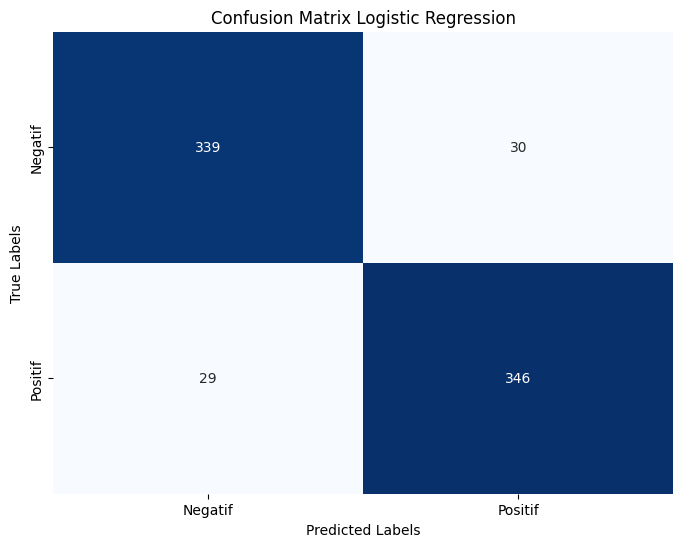

Logistic Regression
Accuracy  =  92.07 %
Recall    =  92.27 %
Precision =  92.02 %
F1-Score  =  92.14 %


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

conf_matrix_lr = confusion_matrix(y_lr_test, predictions_lr)


plt.figure(figsize=(8, 6))  # Ukuran yang lebih besar untuk HD
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
plt.title('Confusion Matrix Logistic Regression')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print("Logistic Regression")
print('Accuracy  = ', round(accuracy_score(y_lr_test, predictions_lr)*100,2),'%')
print('Recall    = ', round(recall_score(y_lr_test, predictions_lr)*100,2),'%')
print('Precision = ', round(precision_score(y_lr_test, predictions_lr)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_lr_test, predictions_lr)*100,2),'%')

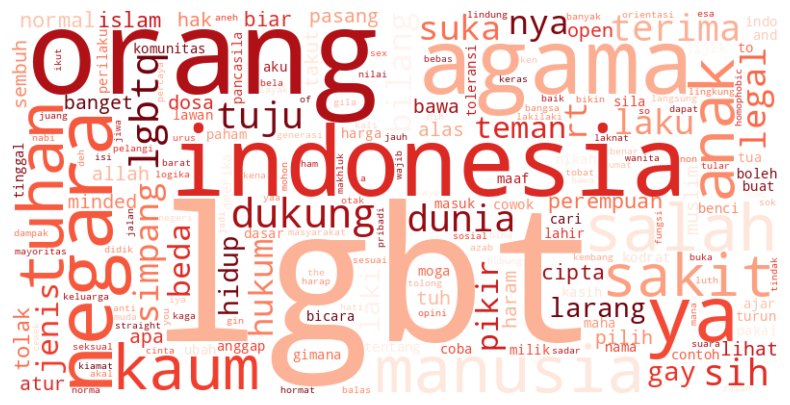

In [22]:
from wordcloud import WordCloud
data_negatif = df[df['label'] == 'kontra']

all_tokens = []
for tokens_list in data_negatif['Tweet']:
    all_tokens.extend(tokens_list)

# Menghitung kemunculan setiap kata
word_count = {}
for token in all_tokens:
    if token in word_count:
        word_count[token] += 1
    else:
        word_count[token] = 1

# Membuat Word Cloud
wordcloud = WordCloud(colormap='Reds', width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

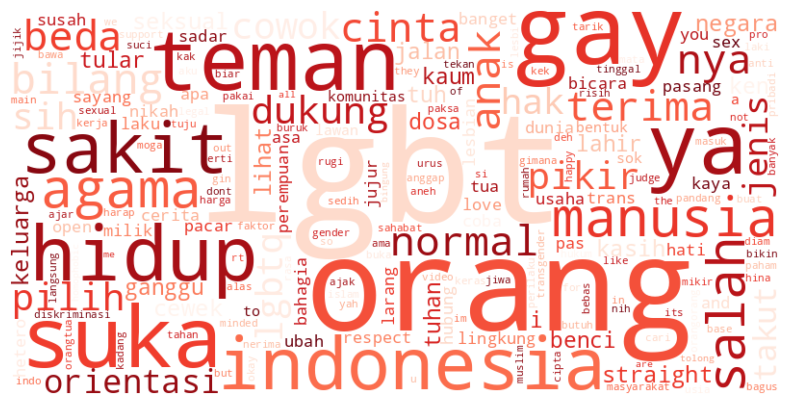

In [23]:
from wordcloud import WordCloud
data_positif = df[df['label'] == 'pro']

all_tokens = []
for tokens_list in data_positif['Tweet']:
    all_tokens.extend(tokens_list)

# Menghitung kemunculan setiap kata
word_count = {}
for token in all_tokens:
    if token in word_count:
        word_count[token] += 1
    else:
        word_count[token] = 1

# Membuat Word Cloud
wordcloud = WordCloud(colormap='Reds', width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()